# Model Training - MobileNetV2 (transfer + data augmentation)

### 0. Imports

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau
)
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.metrics import Precision, Recall
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model

### 1. Paths

In [2]:
# DATASET_BASE_TRAIN_PATH = "/Users/adamdabkowski/DataspellProjects/Praca_dyplomowa/data/train_resized"
# DATASET_BASE_TRAIN_PATH = "/Users/adamd/DataspellProjects/Facial Expressions Recognition/data/train_resized"
# DATASET_BASE_TRAIN_PATH = "/Users/adamd/DataspellProjects/Facial Expressions Recognition/data/train_merged"
DATASET_BASE_TRAIN_PATH = "/Users/adamd/DataspellProjects/Facial Expressions Recognition/data/train_merged_cleaned"

# DATASET_BASE_TRAIN_PATH = "../new_data"

# DATASET_BASE_TEST_PATH = "/Users/adamdabkowski/DataspellProjects/Praca_dyplomowa/data/test_resized"
DATASET_BASE_TEST_PATH = "/Users/adamd/DataspellProjects/Facial Expressions Recognition/data/test_resized"

### 2. Data preprocessing

In [3]:
batch_size  = 32
img_size = 224

train_validation_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_validation_data_generator.flow_from_directory(
    DATASET_BASE_TRAIN_PATH,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    subset='training',
    shuffle=True,
)

validation_generator = train_validation_data_generator.flow_from_directory(
    DATASET_BASE_TRAIN_PATH,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation',
    shuffle=True,
)

Found 23689 images belonging to 7 classes.
Found 5919 images belonging to 7 classes.


### 5. Model creating

In [4]:
CATEGORIES = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

In [5]:
checkpoint = ModelCheckpoint(
    filepath="./model_mobilenet_v2_transfer_data_augmentation.h5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

reduce_learning_rate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1,
    min_lr=0.00001,
)

callbacks_list = [early_stopping, checkpoint, reduce_learning_rate]

In [6]:
model = Sequential()

base_model = MobileNetV2(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
model.add(base_model)

model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [7]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Precision(class_id=0, name='precision_angry'),
        Precision(class_id=1, name='precision_disgust'),
        Precision(class_id=2, name='precision_fear'),
        Precision(class_id=3, name='precision_happy'),
        Precision(class_id=4, name='precision_neutral'),
        Precision(class_id=5, name='precision_sad'),
        Precision(class_id=6, name='precision_surprise'),
        Recall(name='recall'),
        Recall(class_id=0, name='recall_angry'),
        Recall(class_id=1, name='recall_disgust'),
        Recall(class_id=2, name='recall_fear'),
        Recall(class_id=3, name='recall_happy'),
        Recall(class_id=4, name='recall_neutral'),
        Recall(class_id=5, name='recall_sad'),
        Recall(class_id=6, name='recall_surprise'),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 2,917,447
Trainable params: 2,883,335
Non-trainable params: 34,112
_________________________________________________________________


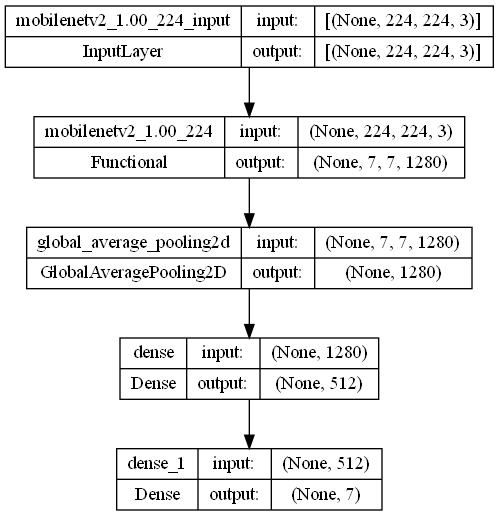

In [8]:
plot_model(model, to_file='model_mobilenet_v2_transfer_data_augmentation.png', show_shapes=True, show_layer_names=True)

### 6. Model training

In [9]:
epochs = 50

In [10]:
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n//train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.n//validation_generator.batch_size,
    callbacks=callbacks_list,
)

Epoch 1/50
740/740 [==============================] - ETA: 0s - loss: 1.4668 - accuracy: 0.4334 - precision: 0.6914 - precision_angry: 0.4427 - precision_disgust: 0.5000 - precision_fear: 0.1765 - precision_happy: 0.7733 - precision_neutral: 0.5358 - precision_sad: 0.4034 - precision_surprise: 0.6656 - recall: 0.2114 - recall_angry: 0.0258 - recall_disgust: 0.0040 - recall_fear: 0.0018 - recall_happy: 0.5514 - recall_neutral: 0.1310 - recall_sad: 0.0301 - recall_surprise: 0.3826
Epoch 1: val_loss improved from inf to 3.09067, saving model to .\model_mobilenet_v2_transfer_data_augmentation.h5
740/740 [==============================] - 866s 1s/step - loss: 1.4668 - accuracy: 0.4334 - precision: 0.6914 - precision_angry: 0.4427 - precision_disgust: 0.5000 - precision_fear: 0.1765 - precision_happy: 0.7733 - precision_neutral: 0.5358 - precision_sad: 0.4034 - precision_surprise: 0.6656 - recall: 0.2114 - recall_angry: 0.0258 - recall_disgust: 0.0040 - recall_fear: 0.0018 - recall_happy: 0.

### 7. Evaluation - Test set

In [3]:
from keras.models import load_model

model = load_model("model_mobilenet_v2_transfer_data_augmentation.h5")

In [4]:
test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_data_generator.flow_from_directory(
    DATASET_BASE_TEST_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 7178 images belonging to 7 classes.


In [5]:
model.evaluate(test_generator)

225/225 [==============================] - 83s 358ms/step - loss: 0.9335 - accuracy: 0.6829 - precision: 0.7337 - precision_angry: 0.6557 - precision_disgust: 0.7183 - precision_fear: 0.6479 - precision_happy: 0.8918 - precision_neutral: 0.6323 - precision_sad: 0.6290 - precision_surprise: 0.8010 - recall: 0.6321 - recall_angry: 0.5626 - recall_disgust: 0.4595 - recall_fear: 0.3252 - recall_happy: 0.8878 - recall_neutral: 0.6707 - recall_sad: 0.4459 - recall_surprise: 0.7894


[0.9334666132926941,
 0.6829200387001038,
 0.7336675524711609,
 0.6557177901268005,
 0.7183098793029785,
 0.6478599309921265,
 0.8918460011482239,
 0.6322630047798157,
 0.6289592981338501,
 0.8009768128395081,
 0.6320702433586121,
 0.5626304745674133,
 0.45945945382118225,
 0.3251953125,
 0.8878241181373596,
 0.6707218289375305,
 0.4458701014518738,
 0.7894103527069092]